# Sensitivity Analysis Experiment

## Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import os
cwd = os.getcwd()
print(cwd)
nwd = os.path.join(cwd, "..", "narratives")
sys.path.insert(0, nwd)

C:\narrative-maps\tests


In [3]:
from matplotlib import pyplot as plt

In [4]:
import networkx as nx

In [5]:
import pydot
from IPython.display import SVG

In [6]:
from packages.solve_LP import *
from packages.graph_utils import *

## Reading Data

In [7]:
def clean_publication(graph_df):
    publication_dict = {'www.bbc.com': 'bbc',
                    'www.aljazeera.com': 'ajz',
                    'www.nytimes.com': 'nyt',
                    'www.theguardian.com': 'tgn',
                    'edition.cnn.com': 'cnn',
                    'www.cnn.com': 'cnn',
                    'Reuters': 'reu',
                    'www.reuters.com': 'reu',
                    'Business Insider': 'bin',
                    'CNN': 'cnn',
                    'The Hill': 'hill',
                    'The New York Times': 'nyt',
                    'CNBC': 'cnbc',
                    'Breitbart': 'brb',
                    'www.breitbart.com': 'brb',
                    'Fox News': 'fox',
                    'www.foxnews.com': 'fox',
                    'CIA': 'cia',
                    'FBI': 'fbi',
                    'Army CID': 'cid',
                    'INS': 'ins',
                    'Sanctioned Intercepts': 'sai',
                    'NSA': 'nsa',
                    'abcnews.go.com': 'abc',
                    'apnews.com': 'apn',
                    'www.firstpost.com': 'fpost',
                    'theconversation.com': 'tcon',
                    'nypost.com': 'nyp',
                    'newscomworld.com': 'nwc',
                    'havanatimes.org': 'hvt',
                    'www.nbcnews.com': 'nbc',
                    'www.local10.com': 'l10',
                    'www.trtworld.com': 'trt',
                    'www.washingtonpost.com': 'wapo',
                    'www.xinhuanet.com': 'xinhua'
                    }
    graph_df['publication'] = graph_df['publication'].map(publication_dict).fillna('default')
    return graph_df

In [8]:
def read_query(dataset, start_date=None, end_date=None, partial=False):
    data_file = str(dataset) + '.csv'
    data_file_path = os.path.join(cwd, "..", "data", data_file)
    if partial:
        columns_to_skip = 'embed'
        query = pd.read_csv(data_file_path, usecols=lambda x: x not in columns_to_skip)
    else:
        query = pd.read_csv(data_file_path)
    query = clean_publication(query)

    # Inferring datatime format (this might bring issues depending on the data!)
    query['date'] = pd.to_datetime(query['date'], infer_datetime_format=True) #8/22/2019 12:15

    if start_date is not None:
        query = query[(query['date'] >= pd.to_datetime(start_date, format='%Y-%m-%d'))]

    if end_date is not None:
        query = query[(query['date'] <= pd.to_datetime(end_date, format='%Y-%m-%d'))]

    if not partial:
        embed_list = ['embed']
        query[embed_list] = query[embed_list].replace(r'( )+', ',', regex=True)
        query[embed_list] = query[embed_list].replace('\[,', '[', regex=True)
        query[embed_list] = query[embed_list].replace(',]', ']', regex=True)
        query[embed_list] = query[embed_list].applymap(literal_eval).applymap(np.array)

        if 'cluster_vec' in query.columns: # Predefined clusters!
            query[['cluster_vec']] = query[['cluster_vec']].applymap(literal_eval).applymap(np.array)

    query.reset_index(inplace=True)
    query['id'] = [str(i) for i in list(query.index)]

    return query

## Plots

In [9]:
def plot_complexity_metric(all_iterations, all_complexities, column):
    max_val_list = []
    for idx, complexity in enumerate(all_complexities):
        max_val_list.append(max(complexity[column]))
    max_val = max(max_val_list) 
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax[0].title.set_text('All runs')
    ax[0].set_xlabel('# of Iterations')
    ax[0].set_ylabel(column)
    ax[0].set_ylim(0, max_val)
    ax[1].title.set_text('Average')
    ax[1].set_xlabel('# of Iterations')
    ax[1].set_ylabel(column)
    ax[1].set_ylim(0, max_val)
    # All elements    
    for idx, complexity in enumerate(all_complexities):
        ax[0].plot(list(range(len(complexity[column]))), complexity[column], '-r')
    # Average
    max_iter = max(all_iterations)
    extended_metric_list = []
    for idx, complexity in enumerate(all_complexities):
        metric_list_extended = list(complexity[column]) + [list(complexity[column])[-1] for _ in range(max_iter - len(complexity[column]))]
        extended_metric_list.append(metric_list_extended)
    extended_metric_array = np.array(extended_metric_list)
    average_metric = np.nanmedian(extended_metric_array, axis=0)
    ax[1].plot(list(range(max_iter)), average_metric, '-r')
    
def plot_error_rate(all_iterations, all_percents):
    max_val_list = []
    for idx, percent_list in enumerate(all_percents):
        max_val_list.append(max(percent_list))
    max_val = max(max_val_list) 
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax[0].title.set_text('All runs')
    ax[0].set_xlabel('# of Iterations')
    ax[0].set_ylabel('Error Rate')
    ax[0].set_ylim(0, max_val)
    ax[1].title.set_text('Average')
    ax[1].set_xlabel('# of Iterations')
    ax[1].set_ylabel('Error Rate')
    ax[1].set_ylim(0, max_val)
    # All elements
    for idx, percent_list in enumerate(all_percents):
        ax[0].plot(list(range(all_iterations[idx])), percent_list, '-r')
    # Average
    max_iter = max(all_iterations)
    extended_percent_list = []
    for percent_list in all_percents:
        percent_list_extended = percent_list + [percent_list[-1] for _ in range(max_iter - len(percent_list))]
        extended_percent_list.append(percent_list_extended)
    extended_percent_array = np.array(extended_percent_list)
    average_percent = np.nanmedian(extended_percent_array, axis=0)
    ax[1].plot(list(range(max_iter)), average_percent, '-r')

In [10]:
def plot_all(all_iterations, all_percents, all_complexities):
    plot_error_rate(all_iterations, all_percents)
    plot_complexity_metric(all_iterations, all_complexities, column='Nodes')
    plot_complexity_metric(all_iterations, all_complexities, column='Edges')
    plot_complexity_metric(all_iterations, all_complexities, column='Stories')
    plot_complexity_metric(all_iterations, all_complexities, column='Interstory Connections')

## Regularized Linear Program

In [11]:
def create_RLP(query, sim_table, membership_vectors, clust_sim_table, exp_temp_table, ent_table, numclust, relevance_table,
    K, mincover, sigma_t, credibility=[], bias=[], operations=[],
    has_start=True, has_end=False, window_time=None, cluster_list=[], start_nodes=[], end_nodes=[],
    verbose=True, force_cluster=True, previous_varsdict=None):
    
    n = len(query.index) #We can cut out everything after the end.
    # Variable names and indices
    var_i = []
    var_ij = []
    var_k = [str(k) for k in range(0,numclust)]

    for i in range(0, n): # This goes up from 0 to n-1.
        var_i.append(str(i))
        for j in window_i_j[i]:
            if i == j:
                print("ERROR IN WINDOW - BASE")
            var_ij.append(str(i) + "_" + str(j))

    potential_edges = len(var_ij)
    
    # Linear program variable declaration.
    minedge = LpVariable("minedge", lowBound = 0, upBound = 1 * 100)
    node_act_vars = LpVariable.dicts("node_act", var_i, lowBound = 0, upBound = 1 * 100)
    node_next_vars = LpVariable.dicts("node_next", var_ij, lowBound = 0,  upBound = 1 * 100)
    clust_active_vars = LpVariable.dicts("clust_active", var_k, lowBound = 0, upBound = 1 * 100)

    # Create the 'prob' variable to contain the problem data
    prob = LpProblem("StoryChainProblem", LpMaximize)
    # The objective function is added to 'prob' first
    prob += minedge * potential_edges - lpSum([node_next_vars[ij] for ij in var_ij]), "WeakestLink"

    # Check duplicates in interactions
    replace = [False] * len(operations)
    for idx, op in enumerate(operations):
        op_ref = op.split(":",1)[1]
        for k in range(idx):
            if op_ref == operations[k].split(":",1)[1]:
                replace[k] = True
    # Fixtures.
    min_threshold_edge = 0.1 / K  * 100
    min_threshold_node = 0.4 / K  * 100
    for idx, op in enumerate(operations):
        op_ref = op.split(":",1)[1]
        # Omit ACL in this part, handle separetely.
        if "ACL" in op:
            continue

        temp = ""
        if "-" in op_ref:
            i = int(op_ref.split("-",1)[0])
            j = int(op_ref.split("-",1)[1])
            temp = str(i) + "_" + str(j)
        else:
            i = int(op_ref)
            temp = str(i)
        op_ref = temp

        if "AN" in op:
            if verbose:
                print('AddedNode ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('RemovedNode' + str(op_ref)) is not None:
                    del prob.constraints['RemovedNode' + str(op_ref)]
                prob += node_act_vars[str(op_ref)] >= min_threshold_node, 'AddedNode' + str(op_ref) # Makes problem infeasible if we add too many, divide threhsold by K? By number of added constraints?
        elif "AE" in op:
            if verbose:
                print('AddedEdge ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('RemovedEdge' + str(op_ref)) is not None:
                    del prob.constraints['RemovedEdge' + str(op_ref)]
                if str(op_ref) not in node_next_vars.keys():
                    # Special case for time-based windows where the time difference is too big.
                    # The connection does not exist by default and you need to add the variable manually for the specific edge.
                    node_next_vars[str(op_ref)] = LpVariable("node_next_" + str(op_ref), lowBound=0, upBound=1)
                    if i == j:
                        print("ERROR IN WINDOW - AE")
                    var_ij.append(str(op_ref))#str(i) + "_" + str(j))
                    window_i_j[i].append(j)
                    window_j_i[j].append(i)
                prob += node_next_vars[str(op_ref)] >= min_threshold_edge, 'AddedEdge' + str(op_ref)
        elif "RN" in op:
            if verbose:
                print('RemovedNode ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('AddedNode' + str(op_ref)) is not None:
                    del prob.constraints['AddedNode' + str(op_ref)]
                if prob.constraints.get('AddedNodeCluster' + str(op_ref)) is not None:
                    del prob.constraints['AddedNodeCluster' + str(op_ref)]
                prob += node_act_vars[str(op_ref)] == 0, 'RemovedNode' + str(op_ref)
        elif "RE" in op:
            if verbose:
                print('RemovedEdge ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('AddedEdge' + str(op_ref)) is not None:
                    del prob.constraints['AddedEdge' + str(op_ref)]
                prob += node_next_vars[str(op_ref)] == 0, 'RemovedEdge' + str(op_ref)

    if force_cluster:
        #min_threshold_edge = 0.1 / K
        #min_threshold_node = 0.4 / K
        min_threshold_edge = 0.05 * 100
        min_threshold_node = 0.01 * 100
        for cluster in cluster_list:
            cluster_sorted = sorted(cluster)
            #print("Cluster:")
            #print(cluster_sorted)
            for idx, event in enumerate(cluster_sorted):
                if verbose:
                    print('AddedNodeCluster ' + str(event))
                if prob.constraints.get('RemovedNode' + str(event)) is not None:
                    del prob.constraints['RemovedNode' + str(event)]
                if prob.constraints.get('AddedNodeCluster' + str(event)) is not None:
                    del prob.constraints['AddedNodeCluster' + str(event)]

                prob += node_act_vars[str(event)] >= min_threshold_node, 'AddedNodeCluster' + str(event)
                #print("Filtered cluster " + str(cluster_sorted[(idx + 1):]))
                if len(cluster_sorted[(idx + 1):]) >= 1:
                    for j in cluster_sorted[(idx + 1):]:
                        op_ref = str(event) + "_" + str(j)
                        #print("Forced connections: " + str(op_ref))
                        if str(op_ref) not in node_next_vars.keys():
                            # Special case for time-based windows where the time difference is too big.
                            # The connection does not exist by default and you need to add the variable manually for the specific edge.
                            if event == j:
                                print("ERROR IN WINDOW - ACL")
                            node_next_vars[str(op_ref)] = LpVariable("node_next_" + str(op_ref), lowBound=0, upBound=1)
                            var_ij.append(str(op_ref))
                            window_i_j[event].append(j)
                            window_j_i[j].append(event)
                            #print(window_i_j[i])
                            #print(window_j_i[i])
                    prob += lpSum([node_next_vars[str(event) + "_" + str(j)] for j in cluster_sorted[(idx + 1):]]) >= min_threshold_edge, 'InternalEdgeCluster' + str(event)
                    if verbose:
                        print('InternalEdgeCluster' + str(event) + ":" + str(cluster_sorted[(idx + 1):]))
    #for combination in itertools.combinations(cluster_list,2):
    #    for node_i in combination[0]:
    #        for node_j in combination[1]:
    #            if int(node_i) < int(node_j):
    #                prob += node_act_vars[str(op_ref)] >= min_threshold_node, 'AddedNode' + str(op_ref)

    # Chain restrictions
    if has_start:
        num_starts = len(start_nodes)
        if verbose:
            print("Start node(s):")
            print(start_nodes)
        if num_starts == 0: # This is the default when no list is given and it has a start.
            prob += node_act_vars[str(0)] == 1 * 100, 'InitialNode'
        else:
            if verbose:
                print("Added start node(s)")
                print("--- %s seconds ---" % (time() - start_time))
            initial_energy = 1.0 / num_starts * 100
            earliest_start = min(start_nodes)
            for node in start_nodes:
                prob += node_act_vars[str(node)] == initial_energy, 'InitialNode' + str(node)
            for node in range(0, earliest_start):
                prob += node_act_vars[str(node)] == 0, 'BeforeStart' + str(node)
    if has_end:
        num_ends = len(end_nodes)
        if verbose:
            print("End node(s):")
            print(end_nodes)
        if num_ends == 0: # This is the default when no list is given and it has a start.
            prob += node_act_vars[str(n - 1)] == 1 * 100, 'FinalNode'
        else:
            if verbose:
                print("Added end node(s)")
                print("--- %s seconds ---" % (time() - start_time))
            final_energy = 1.0 / num_ends * 100
            latest_end = min(end_nodes)
            for node in end_nodes:
                prob += node_act_vars[str(node)] == final_energy, 'FinalNode' + str(node)
            for node in range(latest_end + 1, n):
                prob += node_act_vars[str(node)] == 0, 'AfterEnd' + str(node)

    if verbose:
        print("Chain constraints created.")
        print("--- %s seconds ---" % (time() - start_time))
    prob += lpSum([node_act_vars[i] for i in var_i]) == K * 100, 'KNodes'
    
    if verbose:
        print("Expected length constraints created.")
        print("--- %s seconds ---" % (time() - start_time))


    if has_start:
        if verbose:
            print("Equality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for j in range(1, n):
            if j not in start_nodes:
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for i in window_j_i[j]]) == node_act_vars[str(j)], 'InEdgeReq' + str(j)
            else:
                if verbose:
                    print("Generating specific starting node constraints.")
                    print("--- %s seconds ---" % (time() - start_time))
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for i in window_j_i[j]]) == 0, 'InEdgeReq' + str(j)
    else:
        if verbose:
            print("Inequality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for j in range(1, n):
            prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for i in window_j_i[j]]) <= node_act_vars[str(j)], 'InEdgeReq' + str(j)
    if verbose:
        print("In-degree constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    if has_end:
        if verbose:
            print("Equality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for i in range(0, n - 1):
            if i not in end_nodes:
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for j in window_i_j[i]]) == node_act_vars[str(i)], 'OutEdgeReq'  + str(i)
            else:
                if verbose:
                    print("Generating specific starting node constraints.")
                    print("--- %s seconds ---" % (time() - start_time))
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for j in window_i_j[i]]) == 0, 'OutEdgeReq'  + str(i)
    else:
        if verbose:
            print("Inequality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for i in range(0, n - 1):
            prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for j in window_i_j[i]]) <= node_act_vars[str(i)], 'OutEdgeReq'  + str(i)
    if verbose:
        print("Out-degree constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    # Coverage
    if numclust > 1:
        prob += lpSum([clust_active_vars[str(k)] for k in var_k]) >= numclust * mincover * 100, "MinCover"
        for k in range(0, numclust):
            prob += clust_active_vars[str(k)] == lpSum([node_next_vars[str(i) + "_" + str(j)] * sqrt(membership_vectors[i, k] * membership_vectors[j, k]) for i in range(0, n - 1) for j in window_i_j[i]]), "CoverDef" + str(k)
        if verbose:
            print("Clustering constraints created.")
            print("--- %s seconds ---" % (time() - start_time))
    else:
        if verbose:
            print("No clustering constraints created - only 1 cluster.")
            print("--- %s seconds ---" % (time() - start_time))

    # Objective
    for i in range(0, n):
        for j in window_i_j[i]:
            coherence_weights = [0.5, 0.5]
            entity_multiplier = min(1 + ent_table[i, j], 2) # Five or more entities in common means double the connection strength.
            relevance_multiplier = (relevance_table[i] * relevance_table[j]) ** 0.5 # Geometric mean the relevances, multiply based on how far it is from 0.5.
            coherence = (sim_table[i, j] ** coherence_weights[0]) * (clust_sim_table[i, j] ** coherence_weights[1])
            weighted_coherence = min(coherence * entity_multiplier * relevance_multiplier, 1.0)
            prob += minedge <= 1 * 100 - node_next_vars[str(i) + "_" + str(j)] + weighted_coherence * 100, "Objective" + str(i) + "_" + str(j)
    if verbose:
        print("Objective constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    if previous_varsdict:
        current_names = [v.name for v in prob.variables() if "node_act" in v.name]
        if verbose:
            print("Generated list of names.")
            print("--- %s seconds ---" % (time() - start_time))
        for k, v in previous_varsdict.items():
            if "node_act" in k and k in current_names:
                node_act_vars[k.replace("node_act_", "")].setInitialValue(v)

    if verbose:
        if previous_varsdict:
            print("Used previous solution as starting point.")
            print("--- %s seconds ---" % (time() - start_time))
        else:
            print("No previous solution available.")
            print("--- %s seconds ---" % (time() - start_time))
    # The problem data is written to an .lp file
    return prob

## LP Preprocessing

In [12]:
def extract_varsdict(prob):
    # We get all the node_next variables in a dict.
    varsdict = {}
    for v in prob.variables():
        if "node_next" in v.name or "node_act" in v.name:
            varsdict[v.name] = np.clip(v.varValue / 100, 0, 1) # Just to avoid negative rounding errors.
    return varsdict

In [13]:
def solve_LP_from_query(query, dataset,
    operations=[], K = 6, mincover=0.20,
    min_samples=2, min_cluster_size=2,
    n_neighbors=2, min_dist=0.01,
    sigma_t = 30,
    start_nodes=[], end_nodes=[],
    verbose=True, random_state=42,
    force_cluster=True,
    use_entities=True, use_temporal=True, strict_start=False, umap_init='spectral', cosine_sim = True, use_new_LP=False):

    global start_time
    start_time = time()
    # Min-cluster-size = 10, n_neighbors=2
    doc_list = []
    for index, article in query.iterrows():
        doc_list.append(article['embed'])
    X = np.array(doc_list)

    # Find cluster list
    cluster_dict = {}
    for idx, op in enumerate(operations):
        if "ACL" in op:
            op_ref = op.split(":",1)[1]
            # Remove _out (this case only happens if you mark a story node before adding it to the map.)
            node_set = set([int(node.replace('_out', '')) for node in literal_eval(op_ref.split("-",1)[0])])
            cluster_id = int(op_ref.split("-",1)[1])
            if cluster_id not in cluster_dict:
                cluster_dict[cluster_id] = node_set
            else:
                for key, value in cluster_dict.items():
                    if key != cluster_id:
                        cluster_dict[key] = cluster_dict[key].difference(node_set) # Make sure we only keep the latest interaction.
                cluster_dict[cluster_id] = cluster_dict[cluster_id].union(node_set)
    cluster_list = []
    for key, value in cluster_dict.items():
        cluster_list.append([int(node) for node in value])
    if verbose:
        print("Cluster List (base) " + str(cluster_list))

    clusterable_embedding = umap.UMAP(n_neighbors=n_neighbors,  min_dist=min_dist, init=umap_init, random_state=np.random.RandomState(random_state)).fit_transform(X)
    
    if len(cluster_list) > 0:
        target = -np.ones(X.shape[0])
        for clust_idx, cluster in enumerate(cluster_list):
            target[cluster] = clust_idx
        clusterable_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, init=umap_init, random_state=np.random.RandomState(random_state)).fit_transform(X, y=target)
    if verbose:
        print("Computed projection.")
        print("--- %s seconds ---" % (time() - start_time))

    if cosine_sim:
        similarities = np.clip(cosine_similarity(clusterable_embedding), -1 , 1)
        # Force normalize
        sim_table = (1 - np.arccos(similarities) / pi)
        mask = np.ones(sim_table.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        max_value = sim_table[mask].max()
        min_value = sim_table[mask].min()
        sim_table = (sim_table - min_value) / (max_value - min_value)
        sim_table = np.clip(sim_table, 0, 1)
    else:
        dist_mat = distance.cdist(clusterable_embedding, clusterable_embedding, 'euclidean')

        mask = np.ones(dist_mat.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        max_value = dist_mat[mask].max()
        min_value = dist_mat[mask].min()
        dist_mat = (dist_mat - min_value)/(max_value - min_value)
        sim_table = np.clip(1 - dist_mat, -1, 1)
    if verbose:
        print("Computed similarities.")
        print("--- %s seconds ---" % (time() - start_time))


    hdbscan_model = hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size,prediction_data=True)
    labels = hdbscan_model.fit_predict(clusterable_embedding)
    membership_vectors = hdbscan.prediction.all_points_membership_vectors(hdbscan_model)
    numclust = 1
    clust_sim = np.zeros((membership_vectors.shape[0], membership_vectors.shape[0]))
    if verbose:
        print("Computed clustering.")
        print("--- %s seconds ---" % (time() - start_time))

    if len(membership_vectors.shape) > 1:
        numclust = membership_vectors.shape[1]
        membership_vectors[membership_vectors < 1/numclust] = 0
        #np.set_printoptions(threshold=sys.maxsize)
        # If any row is full of zeros replace with uniform distribution.
        membership_vectors[np.all(membership_vectors == 0, axis=1)] = np.ones(numclust) / numclust
        row_sums = membership_vectors.sum(axis=1)
        membership_vectors = membership_vectors / row_sums[:, np.newaxis]
        clust_sim = distance.cdist(membership_vectors, membership_vectors, lambda u,v:distance.jensenshannon(u,v,base=2.0))
    else:
        membership_vectors = np.ones((membership_vectors.shape[0], 1)) # No clusters special case (all noise according to HDBSCAN)

    clust_sim_table = 1 - clust_sim
    if verbose:
        print("Computed clustering similarities.")
        print("--- %s seconds ---" % (time() - start_time))

    n = len(query.index)
    # Compute temporal distances

    varsdict_filename = 'varsdict_' + dataset  + "_" + str(n) + '.pickle'

    temporal_distance_table = compute_temp_distance_table(query, dataset)

    if sigma_t != 0 and use_temporal:
        exp_temp_table = np.exp(-temporal_distance_table / sigma_t)
    else:
        exp_temp_table = np.ones(temporal_distance_table.shape)

    if verbose:
        print("Computed temporal distance table.")
        print("--- %s seconds ---" % (time() - start_time))

    window_time = None
    if sigma_t != 0 and use_temporal:
        window_time = sigma_t * 3 # Days

    if window_time is None:
        for i in range(0, n):
            window_i_j[i] = list(range(i + 1, n))
        for j in range(0, n):
            window_j_i[j] = list(range(0, j))
    else:
        for j in range(0, n):
            window_j_i[j] = []
        for i in range(0, n):
            window_i_j[i] = []
        for i in range(0, n - 1):
            window = 0
            for j in range(i + 1, n):
                if temporal_distance_table[i,j] <= window_time:
                    window += 1
            window = max(min(5, n - i), window)
            window_i_j[i] = list(range(i + 1, min(i + window, n)))
            for j in window_i_j[i]:
                window_j_i[j].append(i)

    if verbose:
        print("Computed temporal windows.")
        print("--- %s seconds ---" % (time() - start_time))

    ent_table, ent_doc_list = get_entity_table(query, dataset)
    if verbose:
        print("Computed entity similarities.")
        print("--- %s seconds ---" % (time() - start_time))
    if not use_entities:
        ent_table = np.zeros(ent_table.shape)

    # Deprecated relevance table computation
    relevance_table = [1.0] * membership_vectors.shape[0] # Create a vector full of 1s
    focus_query = None
    if focus_query: # Uses focus_query (string)
        #torch.cuda.empty_cache()
        model = SentenceTransformer('all-MiniLM-L6-v2')
        q = model.encode(focus_query)
        q = q.reshape(1, -1)
        euc_dist = distance.cdist(q, X, metric='euclidean')
        euc_dist = (euc_dist - np.min(euc_dist)) / (np.max(euc_dist) - np.min(euc_dist))
        sim_list = 1 - euc_dist
        relevance_table = sim_list[0] # Remove one dimension.
        if verbose:
            print("Computed query relevance table.")
            print("--- %s seconds ---" % (time() - start_time))

    has_start = False
    if start_nodes is not None:
        has_start = (len(start_nodes) > 0)
    if end_nodes is not None:
        has_end = (len(end_nodes) > 0)
    if verbose:
        print("Creating LP...")

    # Read previous solution and feed to LP. If none there is no previous solution.
    previous_varsdict = None
    if os.path.isfile(varsdict_filename):
        with open(varsdict_filename, 'rb') as handle:
            previous_varsdict = pickle.load(handle)
    if use_new_LP:
        prob = create_RLP(query, sim_table, membership_vectors, clust_sim_table, exp_temp_table, ent_table, numclust, relevance_table,
            K=K, mincover=mincover, sigma_t=sigma_t,
            operations=operations, cluster_list=cluster_list,
            has_start=has_start, has_end=has_end,
            start_nodes=start_nodes, end_nodes=end_nodes, verbose=verbose, force_cluster=force_cluster)
    else:
        prob = create_LP(query, sim_table, membership_vectors, clust_sim_table, exp_temp_table, ent_table, numclust, relevance_table,
            K=K, mincover=mincover, sigma_t=sigma_t,
            operations=operations, cluster_list=cluster_list,
            has_start=has_start, has_end=has_end,
            start_nodes=start_nodes, end_nodes=end_nodes, verbose=verbose, force_cluster=force_cluster)
    if verbose:
        print("Saving model...")
        print("--- %s seconds ---" % (time() - start_time))
    prob.writeLP("left_story.lp")
    if verbose:
        print("Solving model...")
        print("--- %s seconds ---" % (time() - start_time))
    prob.solve(PULP_CBC_CMD(mip=False, warmStart=True))#(GLPK_CMD(path = 'C:\\glpk-4.65\\w64\\glpsol.exe', options = ["--tmlim", "180"]))


    varsdict = extract_varsdict(prob)
    # Overwrite last solution.
    with open(varsdict_filename, 'wb') as handle:
        pickle.dump(varsdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    graph_df = build_graph_df_multiple_starts(query, varsdict, prune=ceil(sqrt(K)), threshold=0.1/K, cluster_dict=cluster_dict)
    #graph_df = build_graph_df_multiple_starts(query, varsdict, prune=None, threshold=0.0/K, cluster_dict=cluster_dict)

    if verbose:
        print("Graph data frame construction...")
        print("--- %s seconds ---" % (time() - start_time))

    if strict_start:
        graph_df = graph_clean_up(graph_df, start_nodes)

    if verbose:
        print("Graph clean up...")
        print("--- %s seconds ---" % (time() - start_time))

    cluster_assignment = np.argmax(membership_vectors, axis=1)
    scatter_df = pd.DataFrame(data=clusterable_embedding, columns=['X', 'Y'])
    scatter_df['id'] = query['id']
    scatter_df['cluster_id'] = cluster_assignment
    scatter_df['cluster_id'] = scatter_df['cluster_id'].astype(str)
    scatter_df['title'] = query['title']

    if verbose:
        print("Scatter data frame construction...")
        print("--- %s seconds ---" % (time() - start_time))

    return [graph_df, (numclust, LpStatus[prob.status]), scatter_df, sim_table, clust_sim_table, ent_table, ent_doc_list, cluster_assignment, prob]

## LP Wrapper

In [235]:
def generate_map(query, dataset, previous_actions=[], k_input=8, mincover_input=30, window=30, start_nodes=[], end_nodes=[],
                 verbose=True, random_state=42, force_cluster=False, use_temporal=True, use_entities=False, use_new_LP=False):
    operation_list = []
    for item in previous_actions:
        if item.get("action") == "add-node":
            for node in item['content']:
                operation_list.append("AN:" + node)
        elif item.get("action") == "add-edge":
             operation_list.append("AE:" + item["content"])
        elif item.get("action") == "remove-node":
            for node in item['content']:
                operation_list.append("RN:" + node)
        elif item.get("action") == "remove-edge":
            for edge in item['content']:
                operation_list.append("RE:" + edge)
        elif item.get("action") == "add-cluster-list":
             operation_list.append("ACL:" + str(item['content'][0]) + "-" + str(item['content'][1]))
    
    # Solve LP and create new graph_df.
    cluster_size_est = np.sqrt(len(query.index))/2
    cluster_size_est = 5 * round(cluster_size_est / 5) # Round to nearest multiple of 5
    n_neighbors = 2
    if len(query.index) > 40:
        n_neighbors = 10
    elif len(query.index) > 120:
        n_neighbors = cluster_size_est

    graph_df_new, status, scatter_df, sim_table, clust_sim_table, ent_table, ent_doc_list, cluster_assignment, prob = solve_LP_from_query(query, 
        dataset=dataset, operations=operation_list, 
        K=k_input, mincover=mincover_input/100, 
        min_samples=2, min_cluster_size=cluster_size_est, n_neighbors=n_neighbors, min_dist=1/100,
        start_nodes=start_nodes, end_nodes=end_nodes, verbose=verbose, random_state=random_state, force_cluster=force_cluster,
        use_temporal=use_temporal, use_entities=use_entities, use_new_LP=use_new_LP)        

    status_msg = "LP Status: " + status[1] + ", Clusters: " + str(status[0])

    if 'Optimal' in status[1]:
        # Generate graph from LP solution.
        G = build_graph(graph_df_new)
        storylines = graph_stories(G, start_nodes=start_nodes, end_nodes=[])
        status_msg += ", Storylines: " + str(len(storylines))

        # We now apply transitive reduction.
        remove_list_transitive = []
        for story in storylines:
            max_idx = len(story) - 1
            for idx, node in enumerate(story):
                out_edges = G.out_edges(node)
                # If it's not the last element in the story (no need to clean the last one, because there are no in-story outgoing edges)
                if idx != max_idx:
                    for edge in out_edges:
                        if edge[1] in story and edge[1] != story[idx + 1]: # If it's an in-story edge and not the immediately adjacent one.
                            remove_list_transitive.append(edge)
        G.remove_edges_from(remove_list_transitive)
        # We now filter redundant interstory connections.
        remove_list_interstory = []
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            keep_set = set()
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            if len(edge_boundary_list_i) > 0:
                earliest_i = min(edge_boundary_list_i, key = lambda t: (t[0], t[1]))
                latest_i = max(edge_boundary_list_i, key = lambda t: (t[0], t[1]))
            else:
                earliest_i = None
            if len(edge_boundary_list_j) > 0:
                earliest_j = min(edge_boundary_list_j, key = lambda t: (t[1], t[0]))
                latest_j = max(edge_boundary_list_j, key = lambda t: (t[1], t[0]))
            else:
                earliest_j = None
            if not earliest_i and not earliest_j:
                # No connections
                continue
            elif earliest_i and not earliest_j:
                # One-sided.
                if earliest_i == latest_i: # There's only one connection, keep it.
                    continue
                elif earliest_i[0] == latest_i[0]:
                    # This means that the second values are different, but the first one is the same.
                    # For this special case we keep the earliest one.
                    keep_set.add(earliest_i)
                else:
                    # Keep both
                    keep_set.add(earliest_i)
                    keep_set.add(latest_i)
            elif not earliest_i and earliest_j:
                # One-sided and reversed.
                if earliest_j == latest_j: # There's only one connection, keep it.
                    continue
                elif earliest_j[1] == latest_j[1]:
                    # This means that the first values are different, but the second one is the same.
                    # For this special case we keep the earliest one.
                    keep_set.add(earliest_j)
                else:
                    # Keep both
                    keep_set.add(earliest_j)
                    keep_set.add(latest_j)
            else:
                # Two-sided.
                if earliest_i[0] < earliest_j[1]:
                    # E_i happened first. Keep it
                    keep_set.add(earliest_i)
                    if latest_i[0] > latest_j[1]:
                        # L_i happened last. Keep it.
                        keep_set.add(latest_i)
                    else:
                        keep_set.add(latest_j)
                else:
                    # E_j happened first.
                    keep_set.add(earliest_j)
                    if latest_i[0] > latest_j[1]:
                        # E_i happened last. Keep it.
                        keep_set.add(latest_i)
                    else:
                        keep_set.add(latest_j)
            redundant_edge_set = set(edge_boundary_list_i) | set(edge_boundary_list_j)
            remove_list_interstory += list(redundant_edge_set - keep_set)

        G.remove_edges_from(remove_list_interstory)

        for node in G.nodes:
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])
            if sum_node == 0:
                continue
            for u, v, data in G.out_edges(node, data=True):
                G[u][v]['weight'] = -log(exp(-data['weight']) / sum_node)
            sum_node = sum([exp(-G[u][v]['weight']) for u, v, data in G.out_edges(node, data=True)])
        # Update graph_df
        for i, row in graph_df_new.iterrows():
            new_adj_list = [v for u, v in G.out_edges(str(row['id']))]
            new_adj_weights = [exp(-G[u][v]['weight']) for u, v in G.out_edges(str(row['id']))]
            graph_df_new.at[i,'adj_list'] = new_adj_list
            graph_df_new.at[i,'adj_weights'] = new_adj_weights

        for node in G.nodes:  
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])
            if sum_node == 0:
                continue
            for u, v, data in G.out_edges(node, data=True):
                G[u][v]['weight'] = -log(exp(-data['weight']) / sum_node)
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])

        # Update graph_df
        for i, row in graph_df_new.iterrows():
            new_adj_list = [v for u, v in G.out_edges(str(row['id']))]
            new_adj_weights = [exp(-G[u][v]['weight']) for u, v in G.out_edges(str(row['id']))]
            graph_df_new.at[i,'adj_list'] = new_adj_list
            graph_df_new.at[i,'adj_weights'] = new_adj_weights
            
        #print(graph_df_new)
        return G, graph_df_new, storylines, prob
    else:
        print("Error: No optimal solution.")

## GraphViz

In [236]:
def is_path_edge(i, j, val_list):
    k = 0
    while int(val_list[k]) <= int(i):
        if int(val_list[k]) == int(i) and int(val_list[k+1]) == int(j):
            return True
        k += 1
        if k >= len(val_list):
            return False
    return False

In [237]:
def graph_viz_gen(graph_df, sp, full=False, antichains=None):
    col_pol = {'FL': "#021893", 'LL': "#3537ae", 'CM': "#740699", 'LR': "#b70b0b", 'FR': "#990623"}
    transparency = "60" #80 is 50%
    graph_viz_clean = None
    start = int(sp[0])
    end = int(sp[-1])

    graph_viz = "digraph Story { \n" 
    graph_viz += "graph [fontname = \"candara\"];\n"
    graph_viz += "node [shape=none, margin=0, fontname = \"candara\"];\n"
    graph_viz += "edge [fontname = \"calibri light\"];\n"
        
    if antichains is not None:
        graph_viz += "subgraph cluster_antichain { \n"
        graph_viz += "style=filled; color=lightgray; label =<<b>Max Antichain</b>>; labeljust=\"l\"; \n"
        for idx in antichains:
            row = graph_df.loc[graph_df['index'] == idx]
            node_label = '<table><tr><td><b>' + str(row['id']) + " " + row['publication'].values[0] + '</b></td><td>' + row['date'].values[0] + '</td></tr><tr><td colspan="2">' + row['title'].values[0].replace("\"", "'") + '</td></tr></table>'
            #node_label = "{" + "{" + row['publication'].values[0] + "|" + row['date'].values[0] + "}" + "| " + row['title'].values[0].replace("\"", "'") + "}"
            color = "style=filled, fillcolor=\"" + col_pol['LL'] + transparency + "\""
            color += ", color=black"
            url = row['url'].values[0]
            if pd.isna(url):
                href = "href=\"#\""
            else:
                href = "href=\"" + url + "\""
            tooltip = "tooltip=\"" + row['title'].values[0].replace("\"", "'") + "\""
            #graph_viz += "\"" + str(idx) + "\"" + " [label=\"" + node_label + "\", " + color + "] \n"
            graph_viz += "\"" + str(idx) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"
        graph_viz += "} \n"
    for index, row in graph_df.iterrows():
        if antichains is not None:
            if row['id'] not in antichains:
                if row['id'] == end or row['id'] == start:
                    node_label = '<table BORDER="2" CELLSPACING="0"><tr><td><b>' + str(row['id']) + " " + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
                else:
                    node_label = '<table BORDER="0" CELLBORDER="1" CELLSPACING="0"><tr><td><b>' + str(row['id']) + " " + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
                color = "style=filled, fillcolor=\"" +  col_pol['LL'] + transparency + "\""
                url = row['url']
                if pd.isna(url):
                    href = "href=\"#\""
                else:
                    href = "href=\"" + url + "\""
                tooltip = "tooltip=\"" + row['title'].replace("\"", "'") + "\""
                graph_viz += "\"" + str(row['id']) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"
        else:
            if row['id'] == end or row['id'] == start:
                node_label = '<table BORDER="2" CELLSPACING="0"><tr><td><b>' + str(row['id']) + " " + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
                #node_label = "{" + "{" + row['publication'] + "|" + row['date'] + "}" + "| " + row['title'].replace("\"", "'") + "}"
            else:
                node_label = '<table BORDER="0" CELLBORDER="1" CELLSPACING="0"><tr><td><b>' + str(row['id']) + " " + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
           
            color = "style=filled, fillcolor=\"" +  col_pol['LL'] + transparency + "\""
            url = row['url']
            if pd.isna(url):
                href = "href=\"#\""
            else:
                href = "href=\"" + url + "\""
            tooltip = "tooltip=\"" + row['title'].replace("\"", "'") + "\""
            graph_viz += "\"" + str(row['id']) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"
               
        # Edges are always added, regardless of previous status.
        for idx, adj in enumerate(row['adj_list']):
            if is_path_edge(row['id'], adj, sp):
                edge_label = "[ label=\"" + str(round(row['adj_weights'][idx],3)) + "\",penwidth=4]"
            else:
                edge_label = "[ label=\"" + str(round(row['adj_weights'][idx],3)) + "\" ]"
            graph_viz += "\"" + str(row['id']) + "\"" + "->" + "\"" + str(adj) + "\"" + edge_label + " \n"

    graph_viz_clean = graph_viz + "}"
        
    return graph_viz_clean

# Example (COVID-19 Test)

In [482]:
dataset = "cv"
query = read_query(dataset)
sim_table = compute_sim(query)

In [483]:
G, graph_df, storylines, prob = generate_map(query, dataset, start_nodes=[0], end_nodes=[39], k_input=3, mincover_input=0.0, previous_actions=[], verbose=False, random_state=42, use_new_LP=True, use_temporal=False)

In [484]:
graph_df['date'] = graph_df['date'].apply(lambda x: x.strftime("%m/%d/%Y"))

## Generate Viz

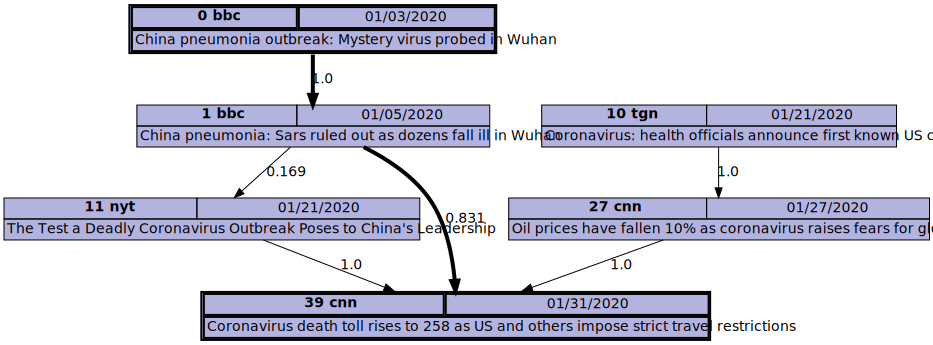

In [485]:
dot_source = graph_viz_gen(graph_df, sp=storylines[0])
text_file = open("test.js", "w")
temp_js = dot_source.replace("C:/Users/brian/Desktop/StoryChains", "./")
n = text_file.write("dotSrc = `" + temp_js + "`")
text_file.close()
    
graphs = pydot.graph_from_dot_data(dot_source)
svg_string = graphs[0].create_svg()
graphs[0].write_svg('test.svg')  
svg_string = svg_string.replace(b"C:/Users/brian/Desktop/StoryChains/", b"")
svg_cut = svg_string.replace(b'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\r\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\r\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\r\n<!-- Generated by graphviz version 2.38.0 (20140413.2041)\r\n -->\r\n<!-- Title: Story Pages: 1 -->\r\n',b'')
svg_cut = svg_string.replace(b'<a xlink:href',b'<a target="_blank" xlink:href')
html_string = b"""<div><style>path:hover{stroke-width:5;stroke:green;transition:0.3s}
            a:hover polygon {
            transition:1.0s;
            fill: #606060!important;
            fill-opacity: 0.2!important;
            opacity: 1.0!important;
            stroke: #646464;
            stroke-width: 1px;
            stroke-linejoin: round;
            }</style></div><div>""" + svg_cut + b"</div>"
with open('test.html', 'wb') as f:
    f.write(html_string)
display(SVG(svg_string))

In [486]:
# Complexity metrics
n_nodes = G.number_of_nodes()# Number of nodes
n_edges = G.number_of_edges()# Number of edges
n_stories = len(storylines)# Number of storylines
n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
total_interstory = 0
for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
    edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
    edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
    total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
# Number of inter-story connections 
complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
print("Complexity: " + str(complexity_list))

Complexity: [6, 6, 3, 2, 1, 3]


## Sensitivity Analysis

In [517]:
res = [{'Name':name,'Price':const.pi,'Slack': const.slack}
                for name, const in prob.constraints.items() if const.slack > 0 and "Objective" in name]

In [518]:
test = [{'Name':name,'Price':const.pi,'Slack': const.slack}
                for name, const in prob.constraints.items() if const.slack == 0 and "Edge" in name and "Objective" not in name]

In [519]:
graph_df

,id,adj_list,adj_weights,date,publication,title,text,url,coherence
0,0,[1],[1.0],01/03/2020,bbc,China pneumonia outbreak: Mystery virus probed...,,https://www.bbc.com/news/world-asia-china-5098...,1.000000
1,1,"[11, 39]","[0.1686044248253615, 0.8313955751746385]",01/05/2020,bbc,China pneumonia: Sars ruled out as dozens fall...,,https://www.bbc.com/news/world-asia-china-5100...,0.358518
2,10,[27],[1.0],01/21/2020,tgn,Coronavirus: health officials announce first k...,,https://www.theguardian.com/society/2020/jan/2...,0.169169
3,11,[39],[1.0],01/21/2020,nyt,The Test a Deadly Coronavirus Outbreak Poses t...,,https://www.nytimes.com/2020/01/21/world/asia/...,0.303144
4,27,[39],[1.0],01/27/2020,cnn,Oil prices have fallen 10% as coronavirus rais...,,https://edition.cnn.com/2020/01/27/business/oi...,0.169169
5,39,[],[],01/31/2020,cnn,Coronavirus death toll rises to 258 as US and ...,,https://edition.cnn.com/2020/01/30/asia/wuhan-...,1.000000


In [520]:
n = len(query)

In [521]:
actual_nodes = []
for v in prob.variables():
    if "node_act" in v.name and v.varValue != 0:
        print(v.name, "=", v.varValue)
        actual_nodes.append(v.name.replace("node_act_",""))
sa = pd.DataFrame(res)

node_act_0 = 100.0
node_act_1 = 35.851778
node_act_10 = 16.916921
node_act_11 = 30.31438
node_act_27 = 16.916921
node_act_39 = 100.0


In [522]:
sa

,Name,Price,Slack
0,Objective0_1,-0.0,63.992662
1,Objective0_2,-0.0,99.857960
2,Objective0_3,-0.0,39.088292
3,Objective0_4,-0.0,24.362876
4,Objective0_5,-0.0,39.293456
...,...,...,...
512,Objective35_36,-0.0,53.940061
513,Objective36_37,-0.0,45.740546
514,Objective36_38,-0.0,45.099305
515,Objective36_39,-0.0,44.997779


In [523]:
#print("Binding constraints")
#with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.6f' % x):
#    print(sa)

In [524]:
source_freq = [0] * n
target_freq = [0] * n

In [525]:
varsdict = {}
for v in prob.variables():
    varsdict[v.name] = v.varValue

In [526]:
for index, row in sa.iterrows():
    if "Objective" in row.Name: 
        nodes = row.Name.replace("Objective","").split("_")
        #print("Binding constraint source: " + nodes[0])
        #print("Binding constraint target: " + nodes[1])
        source_freq[int(nodes[0])] += 1
        target_freq[int(nodes[1])] += 1
        
        #print(varsdict["node_next_" + str(nodes[0]) + "_" + str(nodes[1])])

In [527]:
total_freq = [a + b for a, b in zip(source_freq, target_freq)]

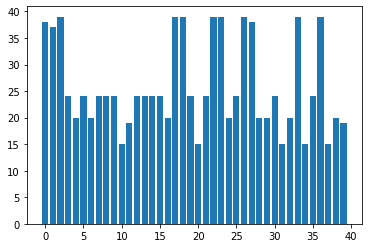

In [528]:
plt.bar(range(n), total_freq)
plt.show()

In [534]:
G = nx.DiGraph()
for index, row in sa.iterrows():
    if "Objective" in row.Name: 
        nodes = row.Name.replace("Objective","").split("_")
        weight = max(0, varsdict['node_next_' + str(nodes[0]) + "_" + str(nodes[1])])
        print(weight, nodes[0], nodes[1])
        if weight > 0:
            G.add_edge(nodes[0], nodes[1], weight=weight / 100)
pos=nx.kamada_kawai_layout(G)

35.851778 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
12.678264 0 10
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
26.48569 0 39
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
4.2386573 1 10
5.3301121 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 28
0 1 29
0 1 30
0 1 31
0 1 32
0 1 33
0 1 34
0 1 35
0 1 36
0 1 37
0 1 38
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 2 20
0 2 21
0 2 22
0 2 23
0 2 24
0 2 25
0 2 26
0 2 27
0 2 28
0 2 29
0 2 30
0 2 31
0 2 32
0 2 33
0 2 34
0 2 35
0 2 36
0 2 37
0 2 38
0 2 39
0 3 5
0 3 7
0 3 8
0 3 9
0 3 12
0 3 13
0 3 14
0 3 15
0 3 17
0 3 18
0 3 19
0 3 21
0 3 22
0 3 23
0 3 25
0 3 26
0 3 27
0 3 30
0 3 33
0 3 35
0 3 36
0 4 6
0 4 11
0 4 16
0 4 17
0 4 18
0 4 22
0 4 23
0 4 24
0 4 26
0 4

In [535]:
shadow_nodes = list(set(G.nodes).difference(actual_nodes))
print(shadow_nodes)
bounding_nodes = list(set(G.nodes).difference(shadow_nodes))
print(bounding_nodes)

[]
['1', '27', '39', '0', '10', '11']


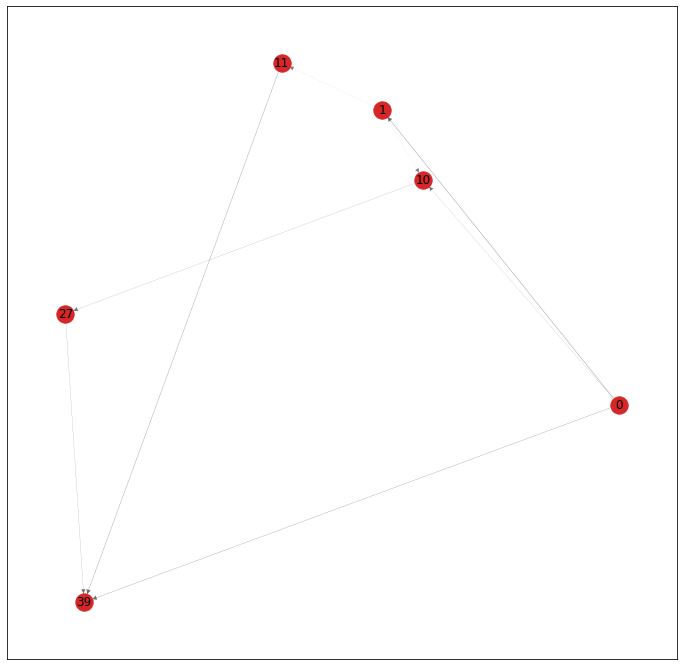

In [536]:
plt.figure(3,figsize=(12,12))
nx.draw_networkx_nodes(G, pos, nodelist=shadow_nodes, node_color="tab:gray")
nx.draw_networkx_nodes(G, pos, nodelist=bounding_nodes, node_color="tab:red")

# use one of the edge properties to control line thickness
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]

nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.show()

In [537]:
H = G.copy()
plt.figure(3,figsize=(12,12))
H.remove_nodes_from(shadow_nodes)
H.add_nodes_from(actual_nodes)
pos = nx.spring_layout(H)
print(H.nodes)

['0', '1', '10', '39', '11', '27']


<Figure size 864x864 with 0 Axes>

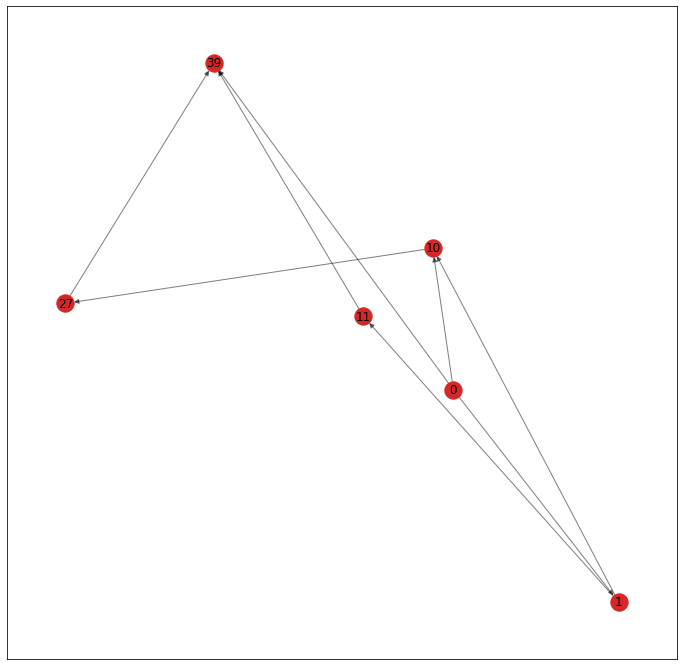

In [538]:
plt.figure(3,figsize=(12,12))
nx.draw_networkx_nodes(H, pos, nodelist=bounding_nodes, node_color="tab:red")
nx.draw_networkx_nodes(H, pos, nodelist=list(set(H.nodes).difference(bounding_nodes)), node_color="tab:green")
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(H, pos)
plt.show()

# Iteration 2: Previous Map + SI

In [312]:
dataset = "cv"
query = read_query(dataset)
sim_table = compute_sim(query)

In [202]:
#previous_actions = [{'action': 'remove-node', 'content': ["1"]}] # 1 is not binding, but the model changes a lot?
previous_actions = [{'action': 'remove-node', 'content': ["18"]}] # 27 is binding and alone.
G, graph_df, storylines, prob = generate_map(query, dataset, start_nodes=[0], end_nodes=[39], k_input=6, mincover_input=0.0, previous_actions=previous_actions, verbose=False, random_state=42, use_new_LP=True)

In [203]:
graph_df['date'] = graph_df['date'].apply(lambda x: x.strftime("%m/%d/%Y"))

## Generate Viz

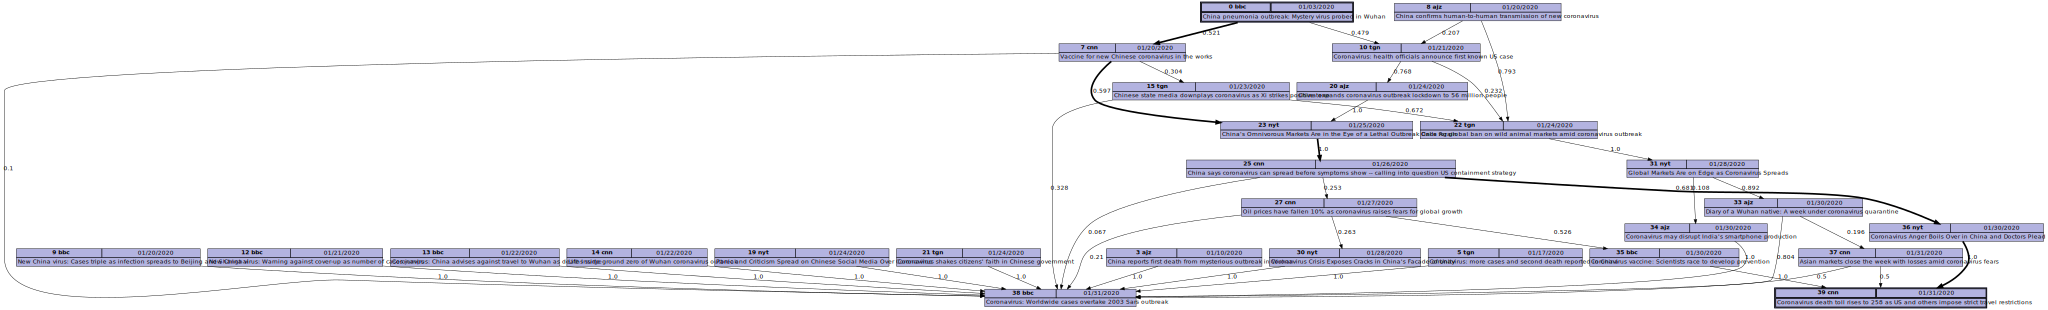

In [204]:
dot_source = graph_viz_gen(graph_df, sp=storylines[0])
text_file = open("test.js", "w")
temp_js = dot_source.replace("C:/Users/brian/Desktop/StoryChains", "./")
n = text_file.write("dotSrc = `" + temp_js + "`")
text_file.close()
    
graphs = pydot.graph_from_dot_data(dot_source)
svg_string = graphs[0].create_svg()
graphs[0].write_svg('test.svg')  
svg_string = svg_string.replace(b"C:/Users/brian/Desktop/StoryChains/", b"")
svg_cut = svg_string.replace(b'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\r\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\r\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\r\n<!-- Generated by graphviz version 2.38.0 (20140413.2041)\r\n -->\r\n<!-- Title: Story Pages: 1 -->\r\n',b'')
svg_cut = svg_string.replace(b'<a xlink:href',b'<a target="_blank" xlink:href')
html_string = b"""<div><style>path:hover{stroke-width:5;stroke:green;transition:0.3s}
            a:hover polygon {
            transition:1.0s;
            fill: #606060!important;
            fill-opacity: 0.2!important;
            opacity: 1.0!important;
            stroke: #646464;
            stroke-width: 1px;
            stroke-linejoin: round;
            }</style></div><div>""" + svg_cut + b"</div>"
with open('test.html', 'wb') as f:
    f.write(html_string)
display(SVG(svg_string))

In [205]:
# Complexity metrics
n_nodes = G.number_of_nodes()# Number of nodes
n_edges = G.number_of_edges()# Number of edges
n_stories = len(storylines)# Number of storylines
n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
total_interstory = 0
for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
    edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
    edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
    total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
# Number of inter-story connections 
complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
print("Complexity: " + str(complexity_list))

Complexity: [27, 38, 16, 4, 12, 27]


## Sensitivity Analysis

In [206]:
res = [{'Name':name,'Price':const.pi,'Slack': const.slack}
                for name, const in prob.constraints.items() if const.slack == 0 and "Objective" in name]

In [207]:
graph_df

,id,adj_list,adj_weights,date,publication,title,text,url,coherence
0,0,"[10, 7]","[0.47864744327088854, 0.5213525567291115]",01/03/2020,bbc,China pneumonia outbreak: Mystery virus probed...,,https://www.bbc.com/news/world-asia-china-5098...,1.000000
1,3,[38],[1.0],01/10/2020,ajz,China reports first death from mysterious outb...,,https://www.aljazeera.com/news/2020/01/china-r...,0.023702
2,5,[38],[1.0],01/17/2020,tgn,Coronavirus: more cases and second death repor...,,https://www.theguardian.com/world/2020/jan/17/...,0.023702
3,7,"[15, 23, 38]","[0.3035403846679868, 0.5967489383039412, 0.099...",01/20/2020,cnn,Vaccine for new Chinese coronavirus in the works,,https://edition.cnn.com/2020/01/20/health/coro...,0.237706
4,8,"[10, 22]","[0.20662489021282152, 0.7933751097871785]",01/20/2020,ajz,China confirms human-to-human transmission of ...,,https://www.aljazeera.com/news/2020/01/china-c...,0.138411
5,9,[38],[1.0],01/20/2020,bbc,New China virus: Cases triple as infection spr...,,https://www.bbc.com/news/world-asia-china-5117...,0.023702
6,10,"[20, 22]","[0.767500354915615, 0.23249964508438503]",01/21/2020,tgn,Coronavirus: health officials announce first k...,,https://www.theguardian.com/society/2020/jan/2...,0.241937
7,12,[38],[1.0],01/21/2020,bbc,New China virus: Warning against cover-up as n...,,https://www.bbc.com/news/world-asia-china-5118...,0.023702
8,13,[38],[1.0],01/22/2020,bbc,Coronavirus: China advises against travel to W...,,https://www.bbc.com/news/world-asia-china-5120...,0.023702
9,14,[38],[1.0],01/22/2020,cnn,Life inside ground zero of Wuhan coronavirus o...,,https://edition.cnn.com/2020/01/22/asia/wuhan-...,0.023702


In [208]:
n = len(query)

In [209]:
actual_nodes = []
for v in prob.variables():
    if "node_act" in v.name and v.varValue != 0:
        print(v.name, "=", v.varValue)
        actual_nodes.append(v.name.replace("node_act_",""))
sa = pd.DataFrame(res)

node_act_0 = 100.0
node_act_10 = 24.19368
node_act_12 = 2.3701824
node_act_13 = 2.3701824
node_act_14 = 2.3701824
node_act_15 = 7.2153364
node_act_19 = 2.3701824
node_act_20 = 38.352862
node_act_21 = 2.3701824
node_act_22 = 33.556024
node_act_23 = 35.631605
node_act_25 = 35.631605
node_act_27 = 9.0036949
node_act_3 = 2.3701824
node_act_30 = 2.3701824
node_act_31 = 27.550823
node_act_33 = 22.466459
node_act_34 = 2.7141809
node_act_35 = 4.7403648
node_act_36 = 24.257728
node_act_37 = 4.7403648
node_act_38 = 71.001907
node_act_39 = 100.0
node_act_4 = -4.0145665e-13
node_act_5 = 2.3701824
node_act_7 = 23.770598
node_act_8 = 13.841126
node_act_9 = 2.3701824


In [210]:
print("Binding constraints")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.6f' % x):
    print(sa)

Binding constraints
              Name     Price     Slack
0    Objective3_38 28.439291 -0.000000
1    Objective5_38 28.439291 -0.000000
2    Objective7_38 28.439291 -0.000000
3    Objective8_10 -0.000000 -0.000000
4    Objective8_38 28.439291 -0.000000
5    Objective9_38 28.439291 -0.000000
6   Objective10_38 28.439291 -0.000000
7   Objective12_38 28.439291 -0.000000
8   Objective13_38 28.439291 -0.000000
9   Objective14_38 28.439291 -0.000000
10  Objective15_38 28.439291 -0.000000
11  Objective19_38 28.439291 -0.000000
12  Objective20_38 28.439291 -0.000000
13  Objective21_38 28.439291 -0.000000
14  Objective25_38 28.439291 -0.000000
15  Objective30_38 28.439291 -0.000000
16  Objective31_38 28.439291 -0.000000
17  Objective34_38 28.439291 -0.000000
18  Objective35_38 28.439291 -0.000000
19  Objective35_39 77.697588 -0.000000
20  Objective37_38 28.439291 -0.000000
21  Objective37_39 77.697588 -0.000000


In [211]:
source_freq = [0] * n
target_freq = [0] * n

In [212]:
varsdict = {}
for v in prob.variables():
    varsdict[v.name] = v.varValue

In [213]:
for index, row in sa.iterrows():
    if "Objective" in row.Name: 
        nodes = row.Name.replace("Objective","").split("_")
        source_freq[int(nodes[0])] += 1
        target_freq[int(nodes[1])] += 1
        if varsdict["node_next_" + str(nodes[0]) + "_" + str(nodes[1])] > 0:
            print("Important?")
            print("Binding constraint source: " + nodes[0])
            print("Binding constraint target: " + nodes[1])

Important?
Binding constraint source: 3
Binding constraint target: 38
Important?
Binding constraint source: 5
Binding constraint target: 38
Important?
Binding constraint source: 7
Binding constraint target: 38
Important?
Binding constraint source: 8
Binding constraint target: 10
Important?
Binding constraint source: 8
Binding constraint target: 38
Important?
Binding constraint source: 9
Binding constraint target: 38
Important?
Binding constraint source: 10
Binding constraint target: 38
Important?
Binding constraint source: 12
Binding constraint target: 38
Important?
Binding constraint source: 13
Binding constraint target: 38
Important?
Binding constraint source: 14
Binding constraint target: 38
Important?
Binding constraint source: 15
Binding constraint target: 38
Important?
Binding constraint source: 19
Binding constraint target: 38
Important?
Binding constraint source: 20
Binding constraint target: 38
Important?
Binding constraint source: 21
Binding constraint target: 38
Important?
B

In [214]:
total_freq = [a + b for a, b in zip(source_freq, target_freq)]

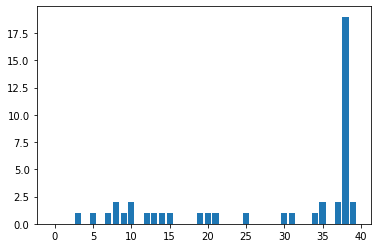

In [215]:
plt.bar(range(n), total_freq)
plt.show()

In [134]:
G = nx.DiGraph()
for index, row in sa.iterrows():
    if "Objective" in row.Name: 
        nodes = row.Name.replace("Objective","").split("_")
        G.add_edge(nodes[0], nodes[1])
pos=nx.circular_layout(G)

In [135]:
shadow_nodes = list(set(G.nodes).difference(actual_nodes))
print(shadow_nodes)
bounding_nodes = list(set(G.nodes).difference(shadow_nodes))
print(bounding_nodes)

[]
['39', '37', '35']


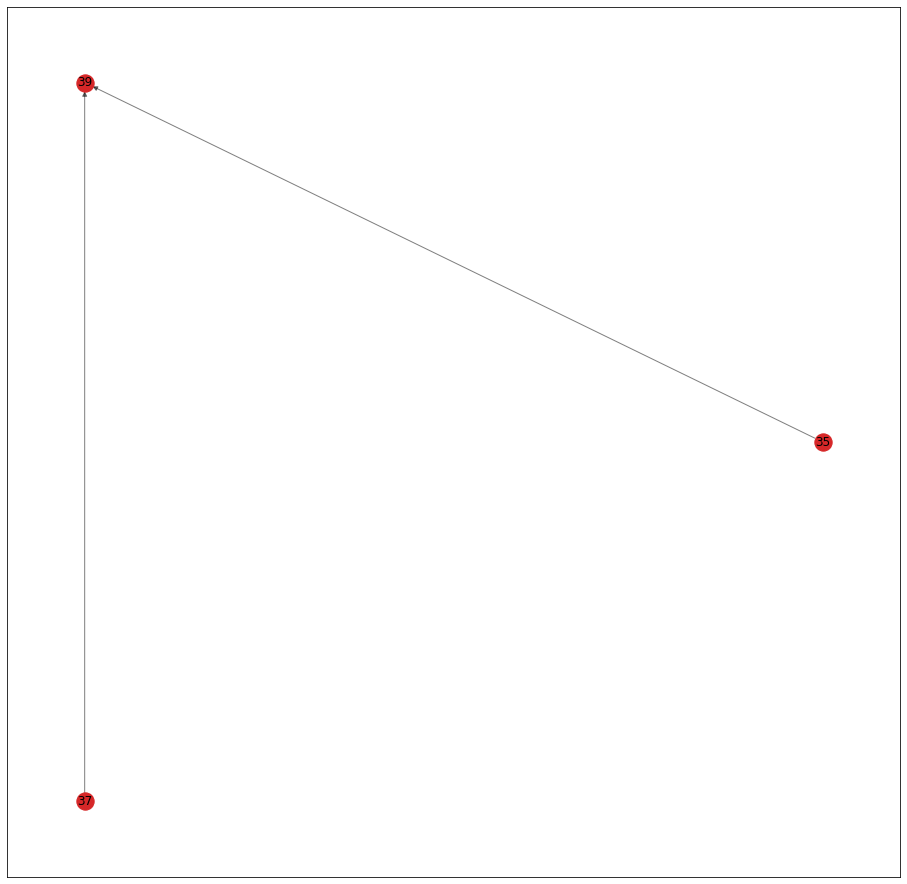

In [136]:
plt.figure(3,figsize=(16,16))
nx.draw_networkx_nodes(G, pos, nodelist=shadow_nodes, node_color="tab:gray")
nx.draw_networkx_nodes(G, pos, nodelist=bounding_nodes, node_color="tab:red")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.show()

In [56]:
H = G.copy()
H.remove_nodes_from(shadow_nodes)
H.add_nodes_from(actual_nodes)
pos = nx.circular_layout(H)
print(H.nodes)

['1', '10', '29', '38', '21', '39', '0', '26']


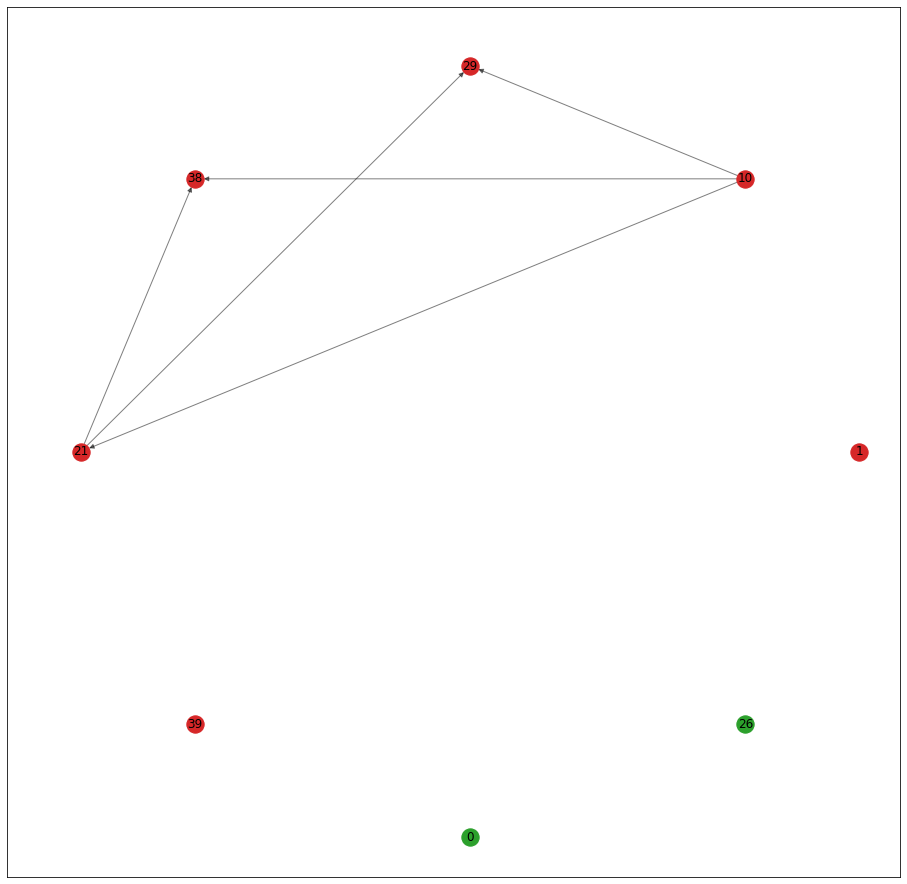

In [57]:
plt.figure(3,figsize=(16,16))
nx.draw_networkx_nodes(H, pos, nodelist=bounding_nodes, node_color="tab:red")
nx.draw_networkx_nodes(H, pos, nodelist=list(set(H.nodes).difference(bounding_nodes)), node_color="tab:green")
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(H, pos)
plt.show()

# Iteration 2

In [162]:
dataset = "cv"
query = read_query(dataset)
sim_table = compute_sim(query)

In [182]:
#previous_actions = [{'action': 'remove-node', 'content': ["1"]}] # 1 is not binding, but the model changes a lot?
previous_actions = [{'action': 'remove-node', 'content': ["38", "18"]}] # 27 is binding and alone.
G, graph_df, storylines, prob = generate_map(query, dataset, start_nodes=[0], end_nodes=[39], k_input=6, mincover_input=0.0, previous_actions=previous_actions, verbose=False, random_state=42, use_new_LP=True)

In [183]:
graph_df['date'] = graph_df['date'].apply(lambda x: x.strftime("%m/%d/%Y"))

## Generate Viz

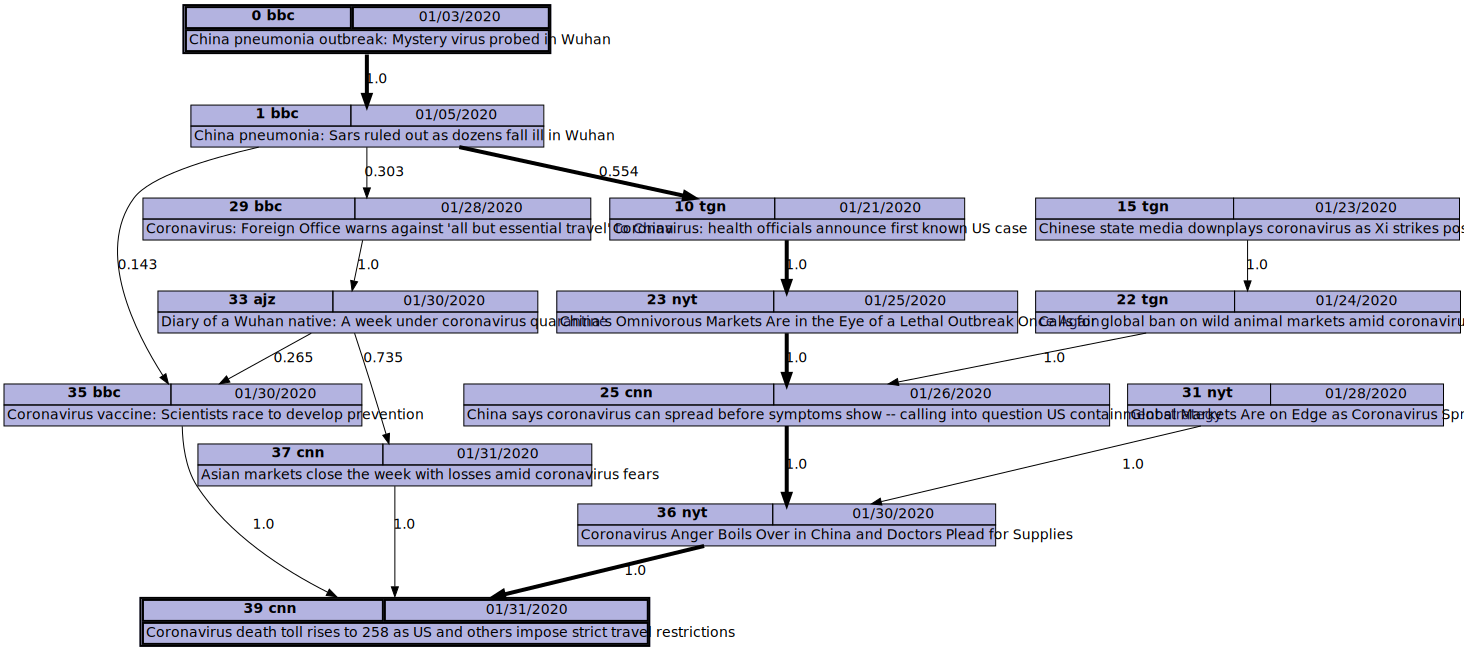

In [184]:
dot_source = graph_viz_gen(graph_df, sp=storylines[0])
text_file = open("test.js", "w")
temp_js = dot_source.replace("C:/Users/brian/Desktop/StoryChains", "./")
n = text_file.write("dotSrc = `" + temp_js + "`")
text_file.close()
    
graphs = pydot.graph_from_dot_data(dot_source)
svg_string = graphs[0].create_svg()
graphs[0].write_svg('test.svg')  
svg_string = svg_string.replace(b"C:/Users/brian/Desktop/StoryChains/", b"")
svg_cut = svg_string.replace(b'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\r\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\r\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\r\n<!-- Generated by graphviz version 2.38.0 (20140413.2041)\r\n -->\r\n<!-- Title: Story Pages: 1 -->\r\n',b'')
svg_cut = svg_string.replace(b'<a xlink:href',b'<a target="_blank" xlink:href')
html_string = b"""<div><style>path:hover{stroke-width:5;stroke:green;transition:0.3s}
            a:hover polygon {
            transition:1.0s;
            fill: #606060!important;
            fill-opacity: 0.2!important;
            opacity: 1.0!important;
            stroke: #646464;
            stroke-width: 1px;
            stroke-linejoin: round;
            }</style></div><div>""" + svg_cut + b"</div>"
with open('test.html', 'wb') as f:
    f.write(html_string)
display(SVG(svg_string))

In [185]:
# Complexity metrics
n_nodes = G.number_of_nodes()# Number of nodes
n_edges = G.number_of_edges()# Number of edges
n_stories = len(storylines)# Number of storylines
n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
total_interstory = 0
for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
    edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
    edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
    total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
# Number of inter-story connections 
complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
print("Complexity: " + str(complexity_list))

Complexity: [14, 16, 5, 3, 2, 7]


## Sensitivity Analysis

In [186]:
res = [{'Name':name,'Price':const.pi,'Slack': const.slack}
                for name, const in prob.constraints.items() if const.slack == 0 and "Objective" in name]

In [187]:
graph_df

,id,adj_list,adj_weights,date,publication,title,text,url,coherence
0,0,[1],[1.0],01/03/2020,bbc,China pneumonia outbreak: Mystery virus probed...,,https://www.bbc.com/news/world-asia-china-5098...,1.000000
1,1,"[35, 29, 10]","[0.14275776082451033, 0.30315848698358566, 0.5...",01/05/2020,bbc,China pneumonia: Sars ruled out as dozens fall...,,https://www.bbc.com/news/world-asia-china-5100...,1.000000
2,10,[23],[1.0],01/21/2020,tgn,Coronavirus: health officials announce first k...,,https://www.theguardian.com/society/2020/jan/2...,0.455629
3,15,[22],[1.0],01/23/2020,tgn,Chinese state media downplays coronavirus as X...,,https://www.theguardian.com/world/2020/jan/24/...,0.051629
4,22,[25],[1.0],01/24/2020,tgn,Calls for global ban on wild animal markets am...,,https://www.theguardian.com/science/2020/jan/2...,0.051629
5,23,[25],[1.0],01/25/2020,nyt,China's Omnivorous Markets Are in the Eye of a...,,https://www.nytimes.com/2020/01/25/world/asia/...,0.297812
6,25,[36],[1.0],01/26/2020,cnn,China says coronavirus can spread before sympt...,,https://edition.cnn.com/2020/01/26/health/coro...,0.518659
7,29,[33],[1.0],01/28/2020,bbc,Coronavirus: Foreign Office warns against 'all...,,https://www.bbc.com/news/uk-51288672,0.249290
8,31,[36],[1.0],01/28/2020,nyt,Global Markets Are on Edge as Coronavirus Spreads,,https://www.nytimes.com/2020/01/28/business/co...,0.114660
9,33,"[35, 37]","[0.26454928074160666, 0.7354507192583933]",01/30/2020,ajz,Diary of a Wuhan native: A week under coronavi...,,https://www.aljazeera.com/news/2020/01/diary-w...,0.249290


In [188]:
n = len(query)

In [189]:
actual_nodes = []
for v in prob.variables():
    if "node_act" in v.name and v.varValue != 0:
        print(v.name, "=", v.varValue)
        actual_nodes.append(v.name.replace("node_act_",""))
sa = pd.DataFrame(res)

node_act_0 = 100.0
node_act_1 = 100.0
node_act_10 = 45.562871
node_act_15 = 5.1629474
node_act_22 = 5.1629474
node_act_23 = 29.78125
node_act_25 = 51.865888
node_act_29 = 24.929031
node_act_31 = 11.465965
node_act_33 = 24.929031
node_act_35 = 18.334074
node_act_36 = 63.331853
node_act_37 = 18.334074
node_act_39 = 100.0
node_act_6 = 1.1400696


In [190]:
print("Binding constraints")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.6f' % x):
    print(sa)

Binding constraints
             Name      Price     Slack
0  Objective35_39 248.333330 -0.000000
1  Objective37_39 248.333330 -0.000000


In [191]:
source_freq = [0] * n
target_freq = [0] * n

In [192]:
varsdict = {}
for v in prob.variables():
    varsdict[v.name] = v.varValue

In [193]:
for index, row in sa.iterrows():
    if "Objective" in row.Name: 
        nodes = row.Name.replace("Objective","").split("_")
        source_freq[int(nodes[0])] += 1
        target_freq[int(nodes[1])] += 1
        if varsdict["node_next_" + str(nodes[0]) + "_" + str(nodes[1])] > 0:
            print("Important?")
            print("Binding constraint source: " + nodes[0])
            print("Binding constraint target: " + nodes[1])

Important?
Binding constraint source: 35
Binding constraint target: 39
Important?
Binding constraint source: 37
Binding constraint target: 39


In [194]:
total_freq = [a + b for a, b in zip(source_freq, target_freq)]

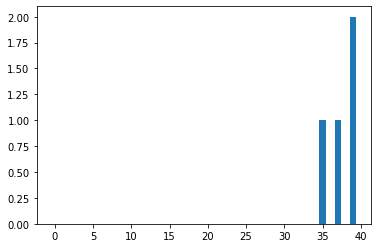

In [195]:
plt.bar(range(n), total_freq)
plt.show()

In [196]:
G = nx.DiGraph()
for index, row in sa.iterrows():
    if "Objective" in row.Name: 
        nodes = row.Name.replace("Objective","").split("_")
        G.add_edge(nodes[0], nodes[1])
pos=nx.circular_layout(G)

In [197]:
shadow_nodes = list(set(G.nodes).difference(actual_nodes))
print(shadow_nodes)
bounding_nodes = list(set(G.nodes).difference(shadow_nodes))
print(bounding_nodes)

[]
['39', '37', '35']


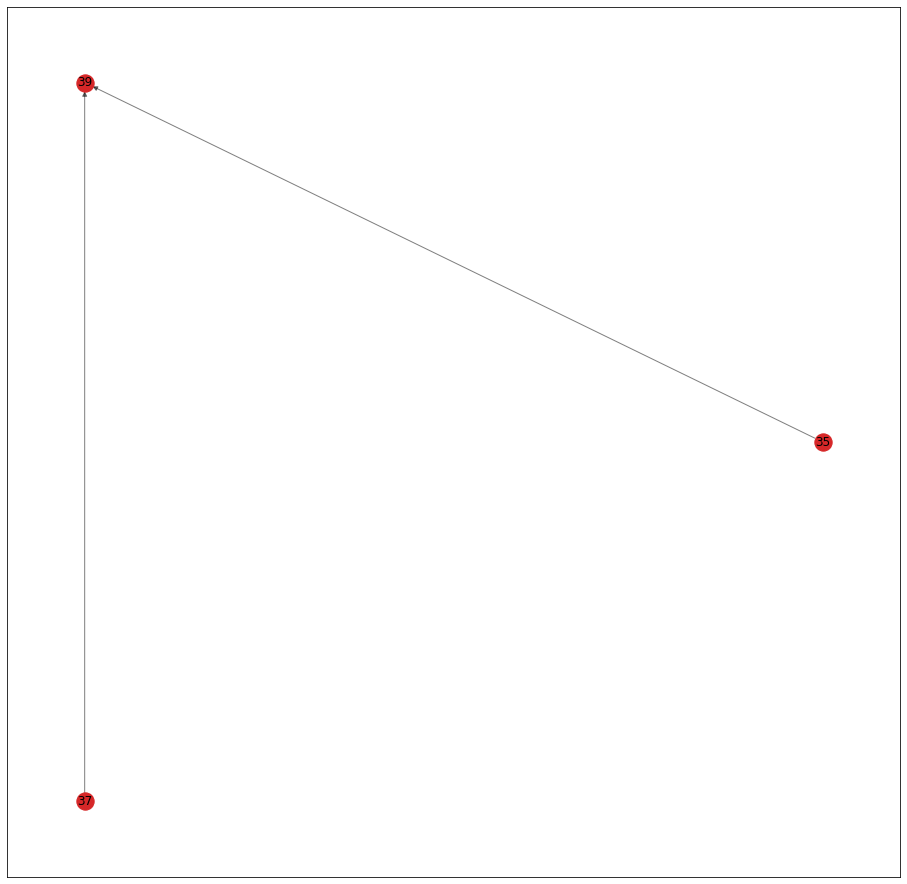

In [198]:
plt.figure(3,figsize=(16,16))
nx.draw_networkx_nodes(G, pos, nodelist=shadow_nodes, node_color="tab:gray")
nx.draw_networkx_nodes(G, pos, nodelist=bounding_nodes, node_color="tab:red")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.show()

In [199]:
H = G.copy()
H.remove_nodes_from(shadow_nodes)
H.add_nodes_from(actual_nodes)
pos = nx.circular_layout(H)
print(H.nodes)

['35', '39', '37', '0', '1', '10', '15', '22', '23', '25', '29', '31', '33', '36', '6']


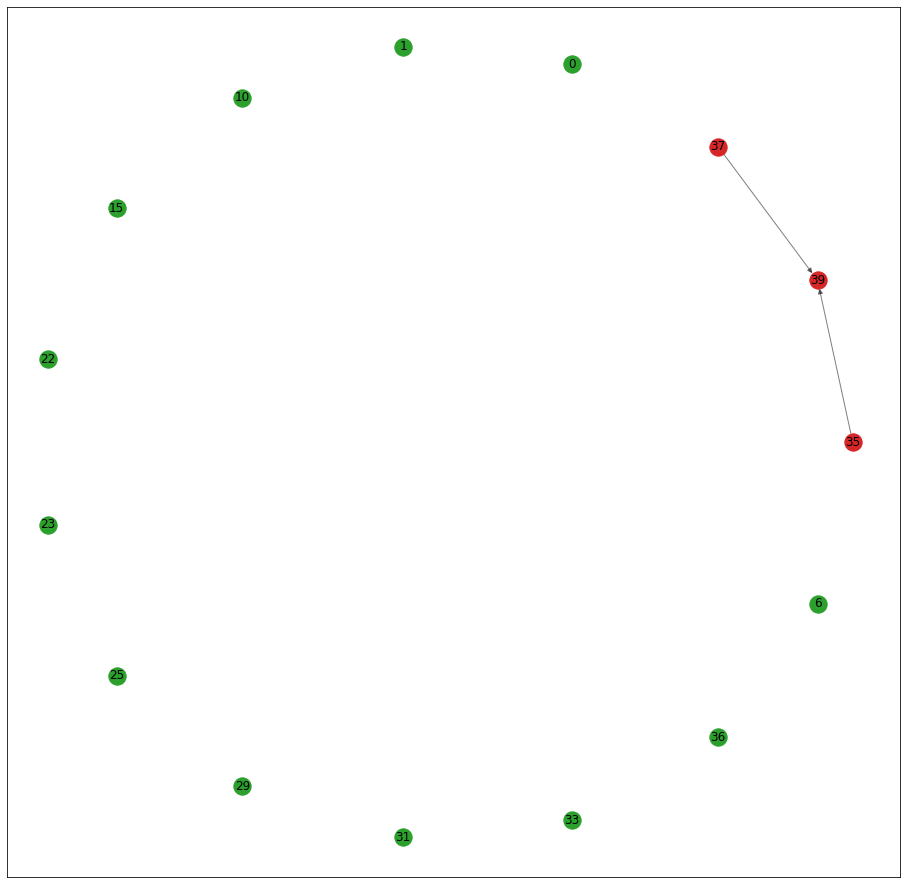

In [200]:
plt.figure(3,figsize=(16,16))
nx.draw_networkx_nodes(H, pos, nodelist=bounding_nodes, node_color="tab:red")
nx.draw_networkx_nodes(H, pos, nodelist=list(set(H.nodes).difference(bounding_nodes)), node_color="tab:green")
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(H, pos)
plt.show()